In [1]:
%load_ext autoreload
#%autoreload 0 #Disable automatic reloading.
#%autoreload 1 #Reload all modules imported with %aimport every time before executing the Python code typed.
#%aimport data_process #List modules which are to be automatically imported or not to be imported.
%autoreload 2 #Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%aimport utils
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import data_process as dp
from utils import *

 ## getting finam data:  (github.com/ffeast/finam-export)

In [3]:
from finam.export import Exporter, Market, Timeframe
import datetime
import time

def get_asset_data(assetCode):
    exporter= Exporter()
    ind = exporter.lookup(code= assetCode)
    assetId = ind.index.values[0]
    assetName, assetCode, market = ind.values[0]
    return  assetId, assetName, market


def get_data_by_code(assetCode, start_date=datetime.date(2008, 1, 1), end_date = None, timeframe=Timeframe.DAILY ):
    '''gets finam historical data only bue assetCode'''
    ts=2
    assetId, assetName, market = get_asset_data(assetCode)
    print("assetId:{}, assetName:{}, market:{}".format(assetId, assetName, market))
    exporter= Exporter()
    if timeframe >= Timeframe.DAILY:
        print('download all')
        return exporter.download(assetId, market=Market(market), start_date=start_date, end_date= end_date,  timeframe=timeframe)
    
    elif timeframe > Timeframe.TICKS:
        print("timeframe is {}, download by days".format(timeframe) )
        dates =  exporter.download(assetId, market=Market(market), start_date=start_date, end_date= end_date,  timeframe=Timeframe.DAILY).index
        years = dates.year.unique()
        downloaded_list = [] 
        counter = 0
        for year in years:
            y_dates =dates[dates.year==year]
            date_start = datetime.date (y_dates[0].year,y_dates[0].month,y_dates[0].day) 
            date_end = datetime.date (y_dates[-1].year,y_dates[-1].month,y_dates[-1].day) 
            print(date_start, date_end)
            downloaded_list.append(exporter.download(assetId, market=Market(market), start_date=date_start, end_date= date_end,  timeframe=timeframe))
            counter+=1
            if counter==3:
                print('pause {} sec'.format(ts))
                time.sleep(ts)
                counter =0
        return pd.concat(downloaded_list)
        
    elif timeframe == Timeframe.TICKS:
        print("timeframe is {}, download by days".format(timeframe))
        dates =  exporter.download(assetId, market=Market(market), start_date=start_date, end_date= end_date,  timeframe=Timeframe.DAILY).index
        time.sleep(ts)
        downloaded_list = [] 
        counter = 0
        for d in dates:
            date = (datetime.date(d.year,d.month,d.day)) 
            print (date)
            downloaded_list.append(exporter.download(assetId, market=Market(market), start_date=date, end_date= date,  timeframe=timeframe))
            counter+=1
            if counter==3:
                print('pause {} sec'.format(ts))
                time.sleep(ts)
                counter =0
        return pd.concat(downloaded_list)
            

In [4]:
data = get_data_by_code("RTS",start_date=datetime.date(2006, 1, 1),timeframe=Timeframe.DAILY)
data.columns = [col.replace("<","").replace(">","").lower() for col in data.columns]
print(f'data.shape:{data.shape}')

data.head()

assetId:17455, assetName:RTS, market:14
download all
http://export.finam.ru/table.csv?d=d&f=table&e=.csv&dtf=1&tmf=3&MSOR=0&mstime=on&mstimever=1&sep=3&sep2=1&at=1&p=8&em=17455&market=14&df=1&mf=0&yf=2006&dt=29&mt=5&yt=2020&cn=RTS&code=RTS&datf=5
data.shape:(3624, 5)


,open,high,low,close,vol
index,,,,,
2006-01-10,113000.0,117840.0,113000.0,117300.0,7734
2006-01-11,117105.0,119260.0,116955.0,119160.0,14413
2006-01-12,119500.0,123600.0,119500.0,122800.0,7854
2006-01-13,122605.0,123500.0,120760.0,121500.0,17760
2006-01-16,121900.0,125550.0,121370.0,125550.0,18321


In [5]:
data.tail()

,open,high,low,close,vol
index,,,,,
2020-06-22,120760.0,124400.0,120740.0,124400.0,590091
2020-06-23,124400.0,125850.0,123900.0,124540.0,477003
2020-06-25,124500.0,124500.0,120780.0,124400.0,659351
2020-06-26,124390.0,124480.0,121020.0,122200.0,547796
2020-06-29,122200.0,122450.0,120270.0,121310.0,320219


# future engeenering

In [6]:
from ta.momentum import *
from ta.trend import *
from ta.volume import *
from ta.others import *
from ta.volatility import *

In [7]:
#set periods for time indicators
col='close'
periods =np.arange(1,84*3,3)
periods

array([  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,
        40,  43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,
        79,  82,  85,  88,  91,  94,  97, 100, 103, 106, 109, 112, 115,
       118, 121, 124, 127, 130, 133, 136, 139, 142, 145, 148, 151, 154,
       157, 160, 163, 166, 169, 172, 175, 178, 181, 184, 187, 190, 193,
       196, 199, 202, 205, 208, 211, 214, 217, 220, 223, 226, 229, 232,
       235, 238, 241, 244, 247, 250])

In [8]:
def make_observations(data,periods, ts=12):
    
    stats=[]
    #Calc indicators stats
    stats.append(get_RSI(data,col,periods).values)
    stats.append(get_williamR(data,col,periods).values)
    stats.append(get_EMA(data,col,periods).values)
    
    # Make lSTM like images of shape N x(time_steps x periods)*num_of_stats
    template = dp.make_lstm_template(len(data), time_steps = ts, stride =1 )
    layers = [dp.to_lstm_array(stat,template)[:,:,:,np.newaxis] for stat in stats]
    observations = np.block(layers)
    return observations

observations = make_observations(data,periods, ts=84)

def min_max_scaling(observations, min=0, max=1):
    images = np.zeros_like(observations)
    for layer in range(images.shape[-1]):
        for i in range(images.shape[0]):
            X= observations[i,:,:,layer]
            Xmin=X.min()
            Xmax=X.max()
            wide = Xmax-Xmin
            if wide!= 0:
                scale = (max-min)/wide
                X_scaled = scale*(X -Xmin) + min 
                #X_scaled = scale*X +min -X.min()*scale            
                images[i,:,:,layer] = X_scaled
    return images    

images = min_max_scaling(observations, min=0, max=255).astype(float)
images.shape

del observations

100%|██████████| 84/84 [00:00<00:00, 434.15it/s]RSI done
Calculating WilliamR

Calculation of WilliamR Done 0.0 minutes 0.0 seconds
EMA done


In [9]:
#split train-test data
TEST_PART = 0.05
start_point = 400
index_train = int(len(data)*(1-TEST_PART))
data_train, images_train = data[start_point:index_train], images[start_point:index_train,:]
data_test, images_test = data[index_train:], images[index_train:,:]
data_test.head(1)

,open,high,low,close,vol
index,,,,,
2019-10-03,130700.0,131110.0,129170.0,130790.0,451599


In [10]:
def mark_observation(observation,action,size=10):
    '''mark observation by action'''
   
    obs = observation.copy()
    obs[0:size,obs.shape[1]-size : obs.shape[1],:]=0
    obs[0:size,obs.shape[1]-size : obs.shape[1],action] = 255
    
    return obs

In [11]:
def make_actions_hist(observation):
    rows = observation.shape[0]
    hist = np.zeros((rows,1,observation.shape[-1]),dtype=float)
    return hist
def update_hist(hist, action,fill_value = 155):
    
    hist[:hist.shape[0]-1,0,:] = hist[1:hist.shape[0],0,:]
    hist[-1,0,:] = 0 
    if action < 3 :
        hist[-1,0,action] = fill_value
    return hist
def append_hist(obs,hist):
    return np.concatenate((obs,hist),axis=1)

(84, 84, 3)


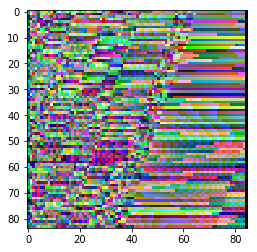

In [12]:
#print one random sample data
obs= images_train[np.random.randint(images_train.shape[0])]
print(obs.shape)
hist = make_actions_hist(obs)

obs = append_hist(obs,hist)

plt.imshow(obs)

(84, 85, 3)


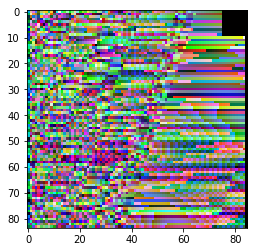

In [13]:
#test how mark_observation work
m_obs=mark_observation(obs,0,10)
print(m_obs.shape)
plt.imshow(m_obs)

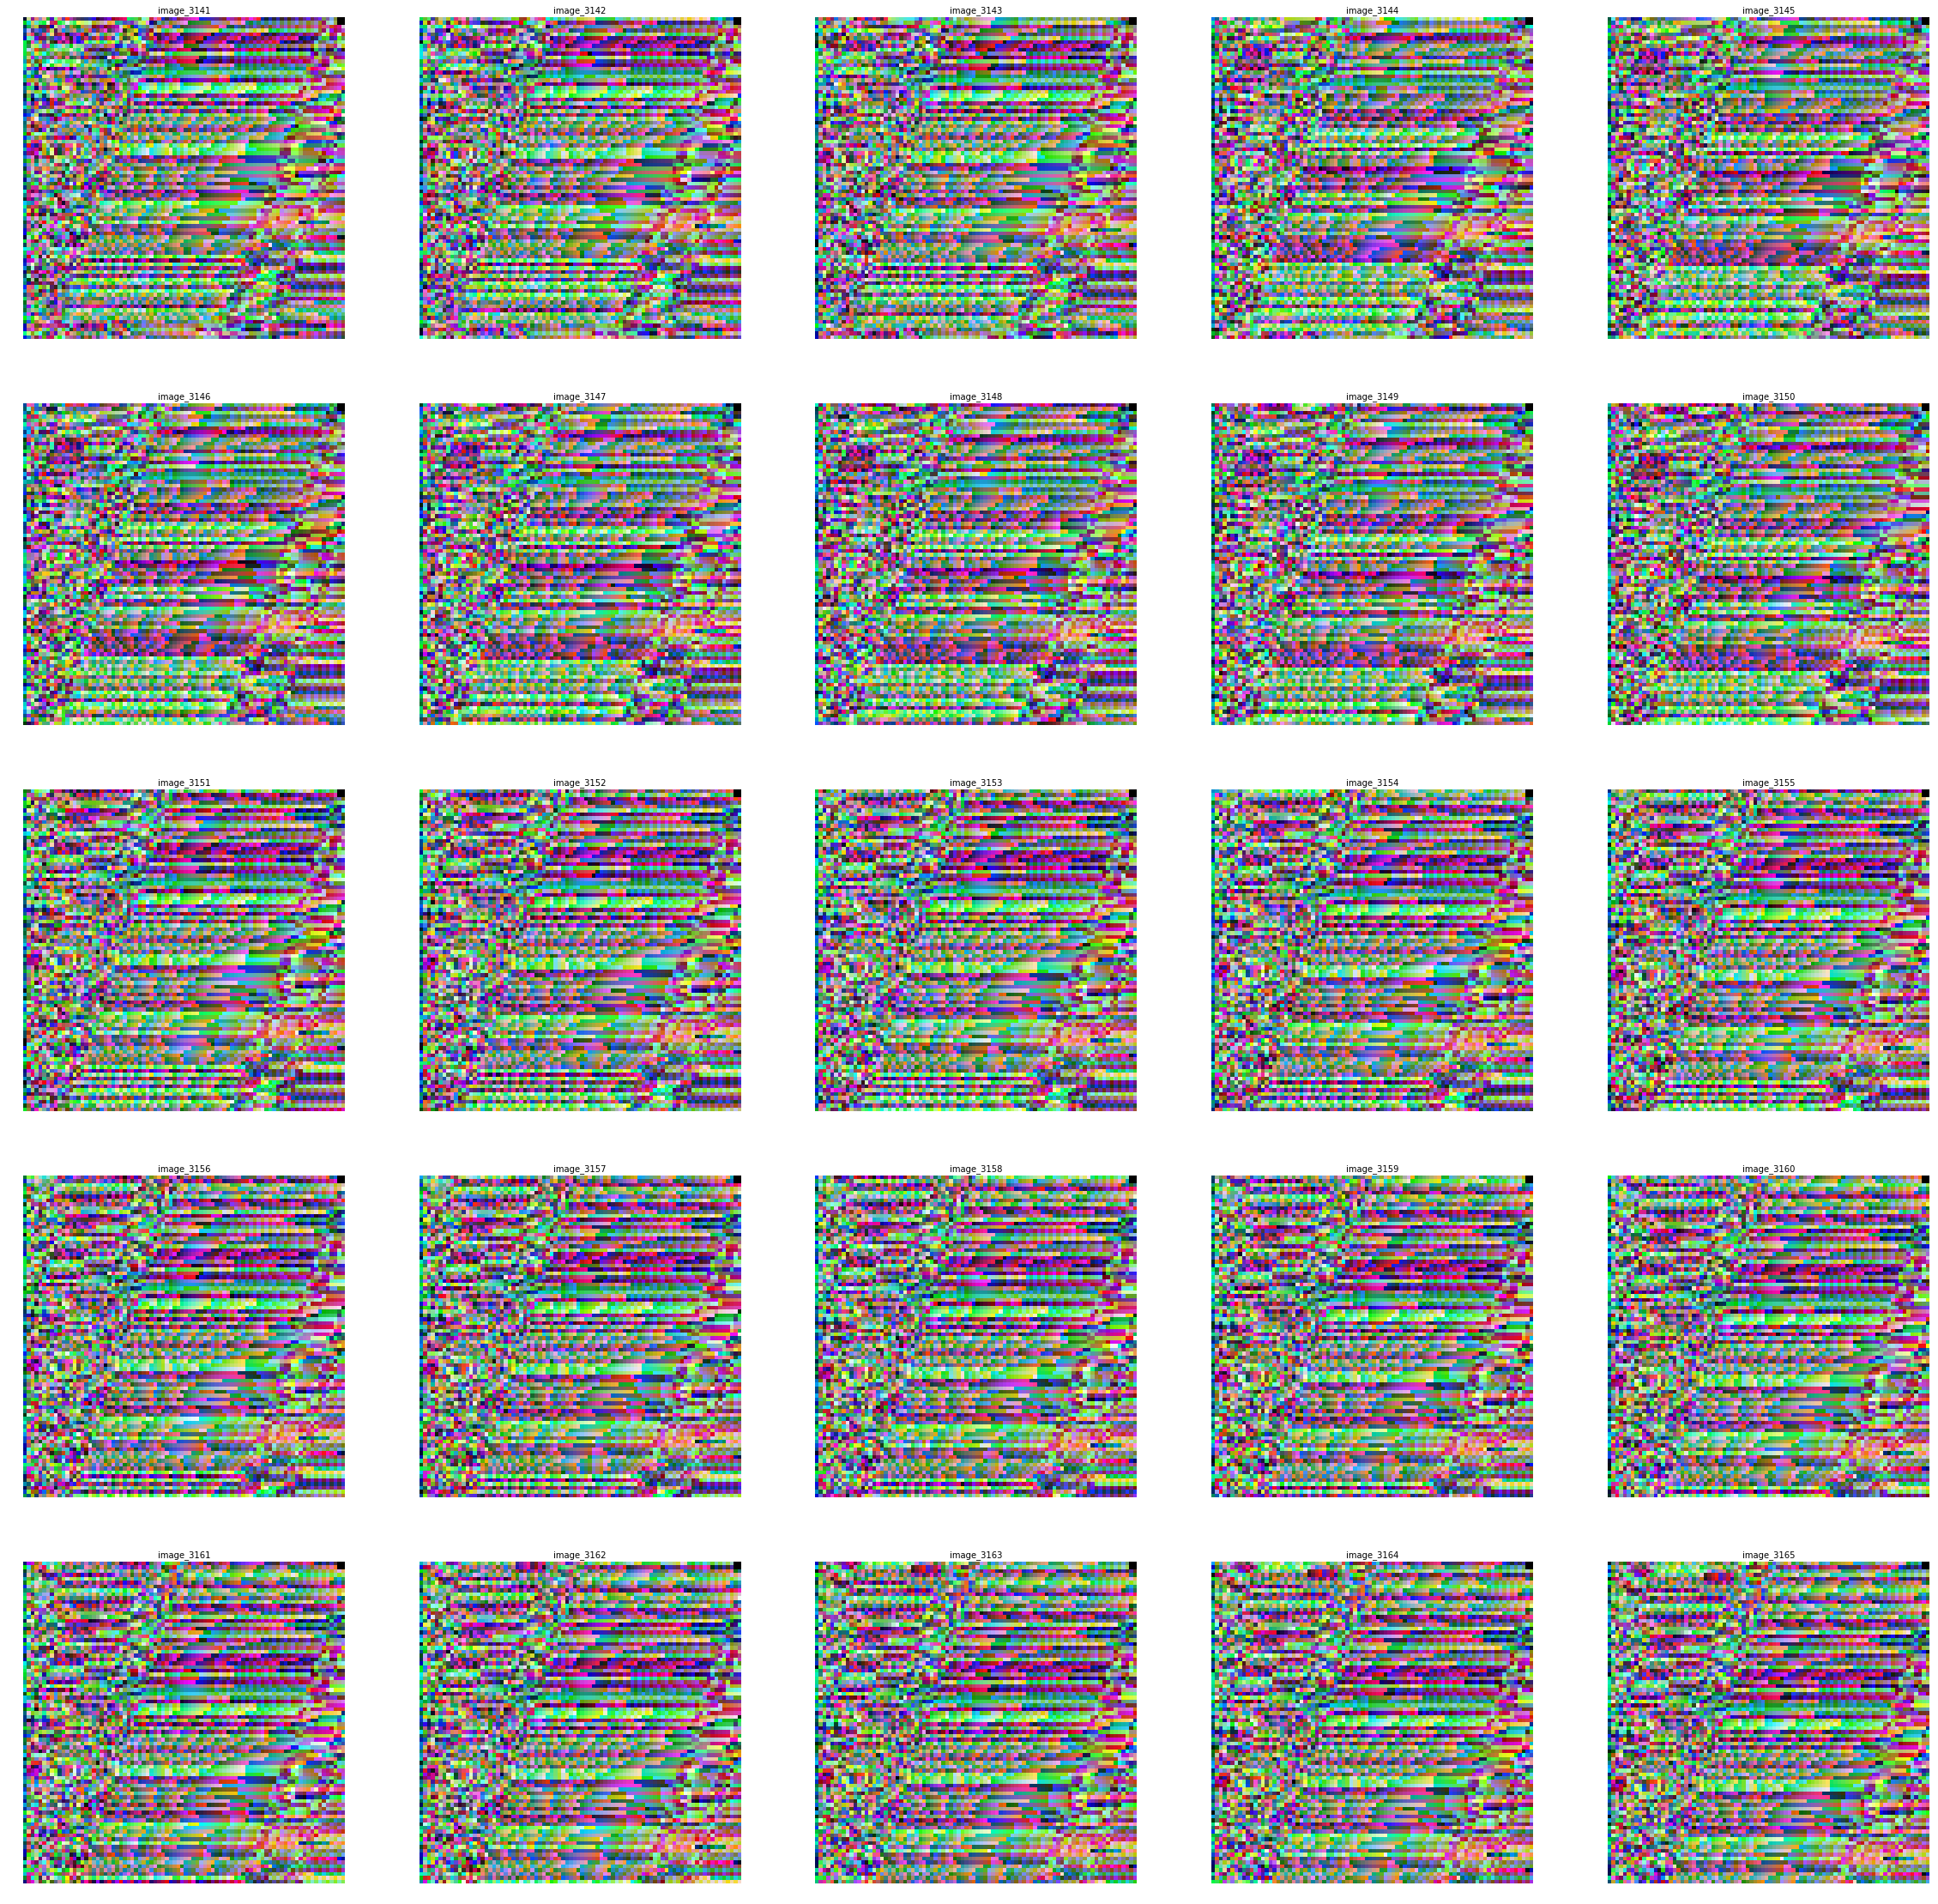

In [14]:

from matplotlib import pyplot as plt
%matplotlib inline
#im = images[:,:,:,:]
im = images.copy()
fig = plt.figure(figsize=(40, 40))
columns = rows = 5
index = np.random.randint(len(im))
for i in range(1, columns*rows +1):
    #index = np.random.randint(len(im))
    
    img = im[index,:]
    img = mark_observation(img,0,2)
    #img = img.reshape(img.shape[0],img.shape[1])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index), fontsize=10)
    #plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
    index+=1
plt.show()

# Stock Trading Enviroment like in  https://github.com/Ploxoy/Stock-Trading-Environment

In [15]:
import random
import json
import gym
from gym import spaces
import pandas as pd
import numpy as np

In [16]:
MAX_ACCOUNT_BALANCE = 1000000 
MAX_NUM_SHARES = 1000
MAX_SHARE_PRICE = 1000000
MAX_OPEN_POSITIONS = 10
MAX_STEPS = 3000
N_DISCRETE_ACTIONS = 4 #   1 - open long, 2 open_short, 3 hold, 4 close all
MAX_DROWDOWN = 0.25
INITIAL_ACCOUNT_BALANCE = 200000


In [17]:
class StockTradingEnvOld(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, stock_data, observation_data):
        super(StockTradingEnv, self).__init__()

        self.df = stock_data
        self.obserations= observation_data
        self.reward_range = (0, MAX_ACCOUNT_BALANCE)

        # Actions of the format Buy x%, Sell x%, Hold, etc.
       # self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        # Prices contains the OHCL values for the last five prices
        HEIGHT= self.obserations.shape[1]
        WIDTH= self.obserations.shape[2]+1
        N_CHANNELS = self.obserations.shape[3]
        #self.observation_space = spaces.Box(low=0, high=1, shape=(6, 6), dtype=np.float16)
        self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
        
        self.max_steps = len(self.df)-1
        self.reset()
        self.hist = make_actions_hist(self.obserations[0,:])
        

    def _next_observation(self):
        
        return self.obserations[self.current_step,:]

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        last_balance = self.balance
        
        current_price = random.uniform(self.df.iloc[self.current_step].open, self.df.iloc[self.current_step].close)

        #print(f'action: {action}')

        if action ==  1: 
            # Buy
            
            if self.shares_held<1:
                
                if self.free_money > current_price:           
                    #print(f'agent will by because action is {action}')
                    self.shares_held+=1
                    self.free_money -= current_price
                
            

        elif action == 2:
            # Sell 
            if self.shares_held>0:
                self.shares_held-=1
                self.free_money += current_price
                self.total_shares_sold+=1
                
        self.balance = self.free_money + self.shares_held*current_price
        
        self.last_reward = (self.balance-last_balance)/current_price
            
                

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        done= False
        self.current_step += 1
        
        if self.balance >= self.max_net_worth:
             self.max_net_worth = self.balance
        
        if self.current_step > self.max_steps:
            self.current_step = 0
            done = True
            
        drow_down = (self.max_net_worth - self.balance)/self.max_net_worth
        if drow_down > MAX_DROWDOWN:
            done = True

        reward = self.last_reward
        if self.net_worth <= 0:
            done = True
        

        obs = self._next_observation()
        self.hist = update_hist(self.hist, action)
        obs = append_hist(obs,self.hist )

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.free_money = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.last_reward = 0
        
       

        # Set the current step to a random point within the data frame
        #self.current_step = random.randint( 0, len(self.df.iloc[:, 'Open'].values) - 6)
        self.current_step = 0
        self.hist = make_actions_hist(self.obserations[0,:])
        obs = self._next_observation()
        obs = append_hist(obs,self.hist)
        return obs

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.balance- INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}',f'Profit: {profit:.2f}')
        
        print(f'In  balance: {self.balance:.2f}', f'free money: {self.free_money:.2f}',f'shares: {self.shares_held:d}')
        print(f'Total sold: {self.total_shares_sold:d}')
      # print(
      #     f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
      # print(
      #     f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
       # print(f'Profit: {profit}')


In [18]:
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, stock_data, observation_data):
        #TODO set trading horizon and random start point
        super(StockTradingEnv, self).__init__()

        self.df = stock_data
        self.obserations= observation_data
        self.reward_range = (0, MAX_ACCOUNT_BALANCE)

        # Actions of the format Buy x%, Sell x%, Hold, etc.
       # self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        # Prices contains the OHCL values for the last five prices
        HEIGHT= self.obserations.shape[1]
        WIDTH= self.obserations.shape[2]+1
        N_CHANNELS = self.obserations.shape[3]
        #self.observation_space = spaces.Box(low=0, high=1, shape=(6, 6), dtype=np.float16)
        self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.float)
        
        self.max_steps = len(self.df)-2
        self.reset()
        self.hist = make_actions_hist(self.obserations[0,:])
        

    def _next_observation(self):
        
        return self.obserations[self.current_step,:]
    
    def open_long(self,cost):
        if self.balance > cost:
            self.shares_held = 1
            
            
        
        
    def open_short(self,cost):
        if self.balance > cost:
            self.shares_held =-1
            
        
    def close_all(self,cost):
        
        if self.shares_held != 0:
            self.shares_held = 0
            self.total_shares_sold+=1
        
    def hold_all(self,cost):
        pass
            
        
    def calc_reward(self,prev_cost, current_cost):
        if self.shares_held !=0:
            self.last_absolute_reward = (current_cost-prev_cost)*self.shares_held
            self.last_reward =self.last_absolute_reward/prev_cost*self.shares_held
        else: 
            self.last_reward = 0.0
    def current_price (self):
        #return random.uniform(self.df.iloc[self.current_step].open, self.df.iloc[self.current_step].close)
        return self.df.iloc[self.current_step].open
   
    def _take_action(self, action):
        # Set the current price to a random price within the time step
        
        last_price = self.last_price
        
        cost = self.current_price()

        self.calc_reward(last_price,cost)
        self.balance+=self.last_absolute_reward
        self.free_money = self.balance - abs(self.shares_held)
        self.last_price=cost
 

        if action ==  1: #close shorts and open long
            if self.shares_held==-1:
                self.close_all(cost)
                self.open_long(cost)
            elif self.shares_held ==0:
                self.open_long(cost)
        
        elif action == 2:
            # Sell - close long and open short
            if self.shares_held == 1:
                self.close_all(cost)
                self.open_short(cost)
            elif self.shares_held == 0:
                self.open_short(cost)
            
                
        elif action == 0:
                #Close all positions
                self.close_all(cost)
                
        elif action == 3:
            #hold position
            self.hold_all(cost)
        self.free_money = self.balance - abs(self.shares_held)*cost    
        
                

    def step(self, action):
        # Execute one time step within the environment
        done= False
        self.current_step += 1
        
        if self.current_step > self.max_steps:
            #self.current_step = 0
            done = True
        
        self._take_action(action)
        
        if self.balance >= self.max_net_worth:
             self.max_net_worth = self.balance
        
            
        drow_down = (self.max_net_worth - self.balance)/self.max_net_worth
        if drow_down > MAX_DROWDOWN:
            done = True
            
        reward = self.last_reward
        
        obs = self._next_observation()
        
        self.hist = update_hist(self.hist, action)
        
        obs = append_hist(obs,self.hist )

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.free_money = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.last_reward = 0
        self.last_absolute_reward = 0
        self.current_step = 0
        self.last_price = self.current_price()
    
       

        # Set the current step to a random point within the data frame
        #self.current_step = random.randint( 0, len(self.df.iloc[:, 'Open'].values) - 6)
        self.hist = make_actions_hist(self.obserations[0,:])
        obs = self._next_observation()
        obs = append_hist(obs,self.hist)

        #TODO reset to random starting position
        return obs

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.balance- INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}',f'Profit: {profit:.2f}')
        
        print(f'In  balance: {self.balance:.2f}', f'free money: {self.free_money:.2f}',f'shares: {self.shares_held:d}')
        print(f'Total sold: {self.total_shares_sold:d}')
      # print(
      #     f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
      # print(
      #     f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
       # print(f'Profit: {profit}')


In [19]:
import gym
import json
import datetime as dt

from stable_baselines.common.policies import MlpPolicy,CnnPolicy,CnnLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2, DQN,A2C




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



(84, 85, 3)

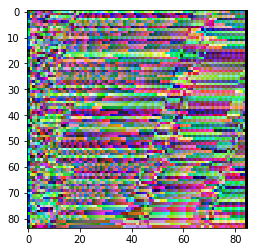

In [20]:
# The algorithms require a vectorized environment to run
env = StockTradingEnv(stock_data=data_train, observation_data=images_train)

env.observation_space

env.action_space

obs = env.reset()
plt.imshow(obs)
obs.shape

In [21]:
data_train.head()

,open,high,low,close,vol
index,,,,,
2007-08-22,183200.0,186670.0,182300.0,185800.0,142943
2007-08-23,187925.0,189000.0,186035.0,186375.0,130811
2007-08-24,185500.0,188005.0,184550.0,187300.0,125017
2007-08-27,188555.0,191050.0,188480.0,190305.0,116152
2007-08-28,189500.0,190095.0,187440.0,187440.0,111537


In [22]:
data_train.tail()

,open,high,low,close,vol
index,,,,,
2019-09-26,134430.0,135310.0,134020.0,134970.0,299459
2019-09-27,134820.0,134990.0,132810.0,133300.0,314116
2019-09-30,133300.0,133810.0,132310.0,132520.0,303784
2019-10-01,132640.0,133920.0,131450.0,132000.0,313743
2019-10-02,131900.0,132190.0,130020.0,130690.0,404897


Step: 240 Profit: -5125.00
In  balance: 194875.00 free money: 12075.00 shares: 1
Total sold: 0
-0.0033802202595136846


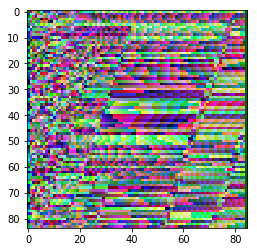

In [23]:
env.reset()
done = False
while not done:
    obs, rewards, done, info=env.step(1)
    #print(env.current_step)
env.render()
print (rewards)
plt.imshow(obs)


In [24]:
env = StockTradingEnv(stock_data=data_train, observation_data=images_train)
obs = env.reset()
model = PPO2('CnnPolicy', env, verbose=1,seed =42,gamma=0.5)
#model = DQN('CnnPolicy', env, verbose=0)

#model = A2C('CnnPolicy', env, verbose=1,seed =42)

Wrapping the env in a DummyVecEnv.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [25]:
#model.learn(total_timesteps=env.max_steps *10)
model.learn(total_timesteps= 1000)

-------------------------------------
| approxkl           | 0.006746498  |
| clipfrac           | 0.0          |
| explained_variance | -25.4        |
| fps                | 85           |
| n_updates          | 1            |
| policy_entropy     | 1.3794839    |
| policy_loss        | -0.014548285 |
| serial_timesteps   | 128          |
| time_elapsed       | 0            |
| total_timesteps    | 128          |
| value_loss         | 0.19136122   |
-------------------------------------
-------------------------------------
| approxkl           | 0.012257718  |
| clipfrac           | 0.16796875   |
| explained_variance | -9.36        |
| fps                | 335          |
| n_updates          | 2            |
| policy_entropy     | 1.3477587    |
| policy_loss        | -0.011498003 |
| serial_timesteps   | 256          |
| time_elapsed       | 1.5          |
| total_timesteps    | 256          |
| value_loss         | 0.011328326  |
-------------------------------------
------------

In [26]:
obs = env.reset()
done= False
while not done:
    action, _states = model.predict(obs,deterministic=True)
    obs, rewards, done, info = env.step(action)
    #env.render()
env.render()

Step: 78 Profit: -51780.00
In  balance: 148220.00 free money: -91485.00 shares: -1
Total sold: 0


In [27]:
env_test =  StockTradingEnv(stock_data=data_test, observation_data=images_test)

In [28]:
obs = env_test.reset()
done= False
while not done:
    action, _states = model.predict(obs,deterministic=True)
    obs, rewards, done, info =env_test.step(action)
    #env.render()
env_test.render()

Step: 181 Profit: 8590.00
In  balance: 208590.00 free money: 86390.00 shares: -1
Total sold: 0


In [29]:
#more tests
number_of_tests = 10
results = []
for i in range(number_of_tests):
    obs = env_test.reset()
    done= False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, info =env_test.step(action)
    results.append(env_test.balance - INITIAL_ACCOUNT_BALANCE)
results
    
    

[8590.0,
 8590.0,
 8590.0,
 8590.0,
 8590.0,
 8590.0,
 8590.0,
 8590.0,
 8590.0,
 8590.0]

In [30]:
#это все почти рандом, денег тут нет need moar tests
